In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [179]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.IsoPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,3)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.333659,0.167318
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,5.166341,-0.167318


In [180]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    if (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
    stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
    print(f"[Local] Grouping box score rows by GameID...")
    groups = stored_game_boxes.groupby('GameID')
    print(f"[Local] Generated {len(groups)} box score groups by GameID.")
    current = 0
    for (name, group) in groups:
        print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
        group_ratings = group['5FR']
        top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
        bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
        group['5FRDiff'] = [top_diff, bot_diff]
        print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
        current+=1
    print(f"[Local] Finished updating box scores with new 5FR margins.")
print(f"[Local] Writing updated box scores to file...")
stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
print(f"[Local] Wrote updated box scores to file.")

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...


KeyboardInterrupt: 

In [166]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Unnamed: 0,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.504055,1.015913,1.008803,1.907384
1,1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.495945,-1.015913,1.008803,1.907384
2,2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.118311,-0.212660,0.211171,0.181656
3,3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.881689,0.212660,0.211171,0.181656
4,4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.713056,-0.807733,0.802080,0.499553


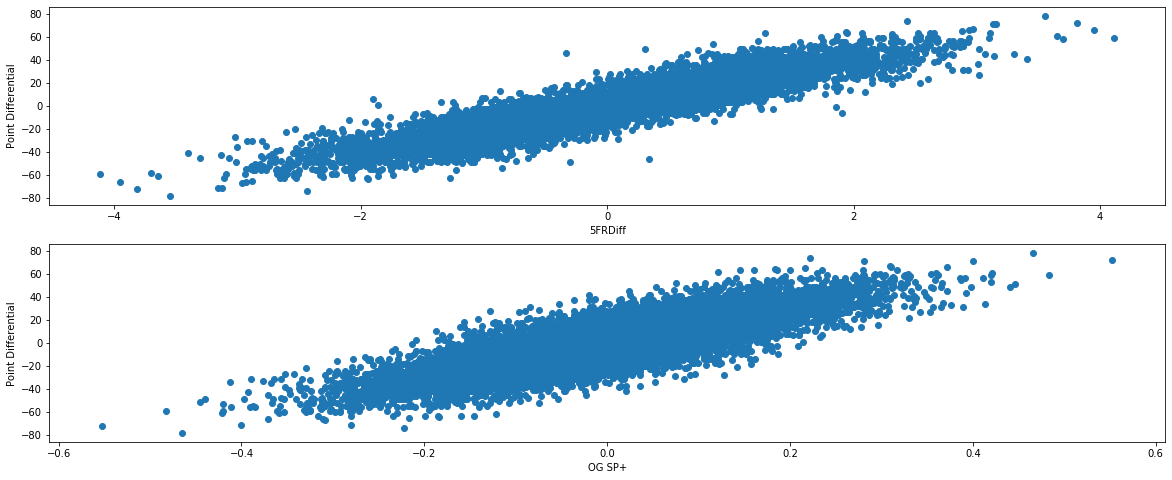

In [167]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(2, figsize=(20, 8))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

In [168]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912025,0.758809
S&PIsoPPPDiff,0.912025,1.000000,0.815979
PtsDiff,0.758809,0.815979,1.000000


In [169]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Unnamed: 0,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.504055,1.015913,1.008803,1.907384
1,1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.495945,-1.015913,1.008803,1.907384
2,2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.118311,-0.212660,0.211171,0.181656
3,3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.881689,0.212660,0.211171,0.181656
4,4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.713056,-0.807733,0.802080,0.499553


In [170]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [171]:
# outliers

In [172]:
train_data.head()

,Unnamed: 0,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.504055,1.015913,1.008803,1.907384
1,1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.495945,-1.015913,1.008803,1.907384
2,2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.118311,-0.212660,0.211171,0.181656
3,3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.881689,0.212660,0.211171,0.181656
5,5,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,...,0.00,0,-0.087917,6.578618,-0.26167,-0.059391,5.286944,0.807733,0.802080,0.499553


In [173]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [174]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 20.18682x + -0.03358
Mean Pred Score: 0.07853429787271247
Pred Std Dev: 20.244298862595517
Mean Abs Error: 6.771086623716551
Mdn Abs Error: 5.229115383388782
R-squared: 0.8366278590404024



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.767623,0.562243,0.493616,0.793105,0.610041,0.619240,0.983577,0.517889,0.781577,-0.468356,-0.452848,0.735533,0.750440,0.246021,0.556612,0.885117,0.914770,0.914770
OffSRDiff,0.767623,1.000000,0.481657,0.304621,0.700581,0.414946,0.457617,0.764582,0.746909,0.730480,-0.321467,-0.171176,0.662507,0.760985,-0.033700,0.560078,0.819874,0.807797,0.807797
OffERDiff,0.562243,0.481657,1.000000,0.149765,0.505336,0.298310,0.311892,0.550688,0.326734,0.797229,-0.183803,-0.110616,0.756347,0.619378,0.571663,0.200498,0.487564,0.549148,0.549148
FPDiff,0.493616,0.304621,0.149765,1.000000,0.609068,0.115220,0.113912,0.476973,0.072732,0.238803,-0.285866,-0.358406,0.237423,0.229923,0.020852,0.278477,0.662467,0.645738,0.645738
OppRateDiff,0.793105,0.700581,0.505336,0.609068,1.000000,0.214722,0.225605,0.792703,0.278372,0.677683,-0.336529,-0.302149,0.607701,0.743577,0.157076,0.520489,0.815443,0.900995,0.900995
OppEffDiff,0.610041,0.414946,0.298310,0.115220,0.214722,1.000000,0.747015,0.603300,0.507128,0.441890,-0.290275,-0.311928,0.419230,0.367893,0.171572,0.326596,0.485156,0.474151,0.474151
OppPPDDiff,0.619240,0.457617,0.311892,0.113912,0.225605,0.747015,1.000000,0.620585,0.559644,0.488930,-0.316887,-0.318048,0.474933,0.385292,0.194880,0.359761,0.543970,0.547063,0.547063
PPDDiff,0.983577,0.764582,0.550688,0.476973,0.792703,0.603300,0.620585,1.000000,0.514636,0.769823,-0.463860,-0.451283,0.725044,0.726329,0.237501,0.559772,0.877826,0.909899,0.909899
OppSRDiff,0.517889,0.746909,0.326734,0.072732,0.278372,0.507128,0.559644,0.514636,1.000000,0.528215,-0.250032,-0.107615,0.493312,0.456277,-0.021451,0.374554,0.573330,0.534085,0.534085
YPPDiff,0.781577,0.730480,0.797229,0.238803,0.677683,0.441890,0.488930,0.769823,0.528215,1.000000,-0.331933,-0.201261,0.925685,0.804684,0.529705,0.463868,0.709003,0.766563,0.766563


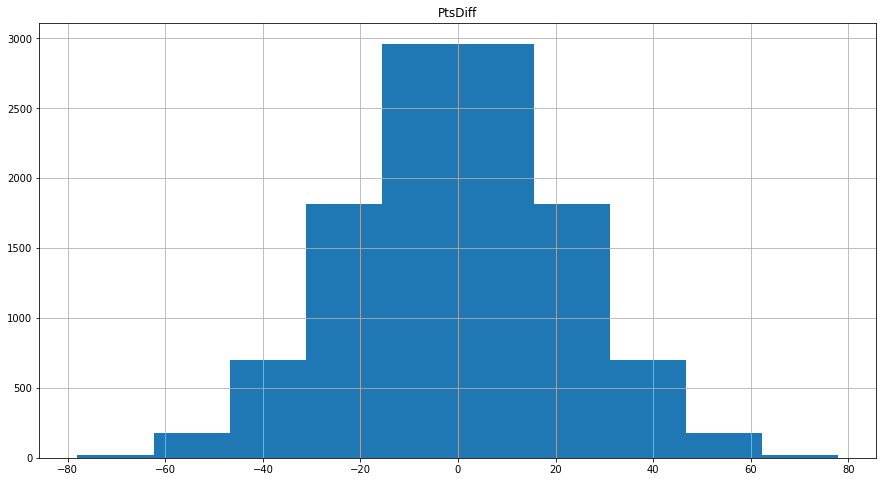

In [175]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

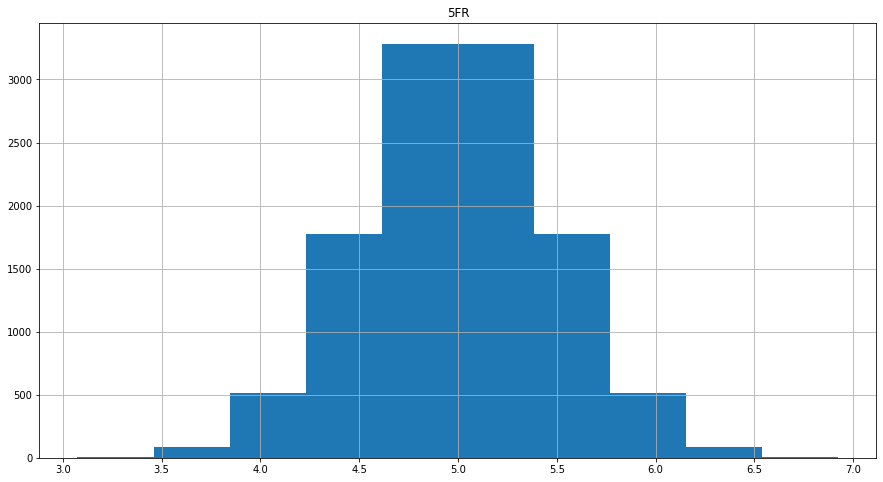

In [176]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

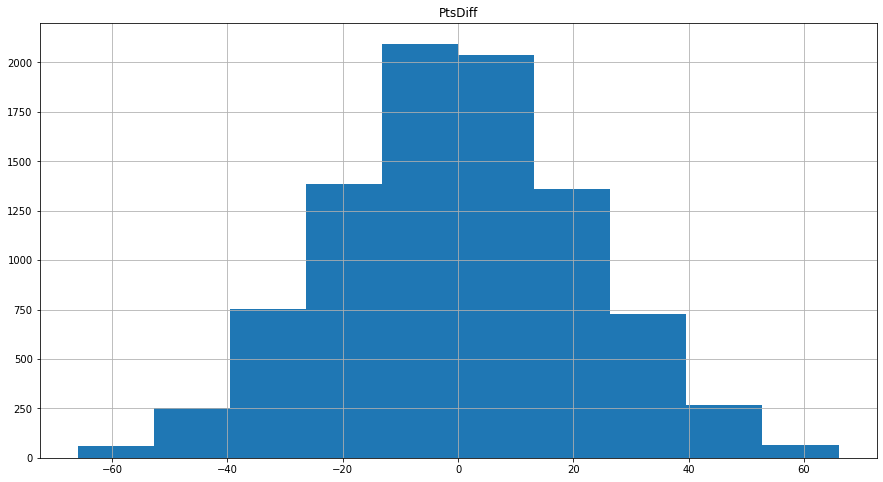

In [177]:
train_data.hist(column='PtsDiff', figsize=(15,8));

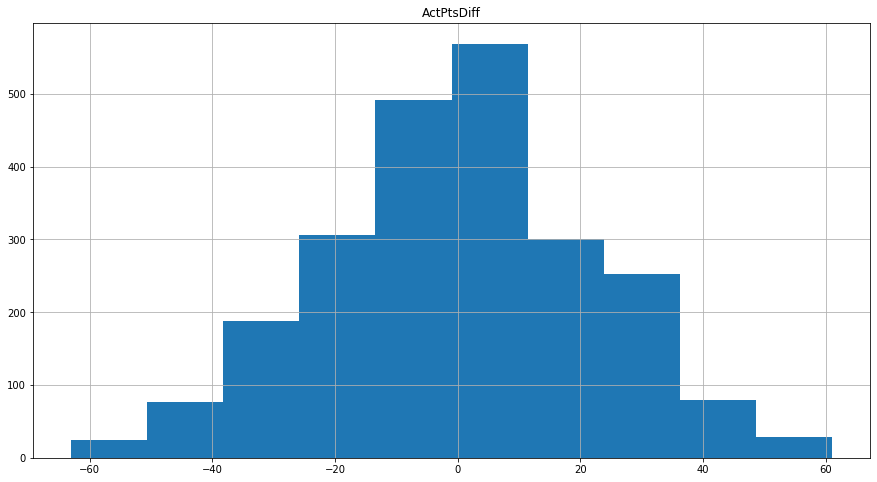

In [178]:
test.hist(column='ActPtsDiff', figsize=(15,8));

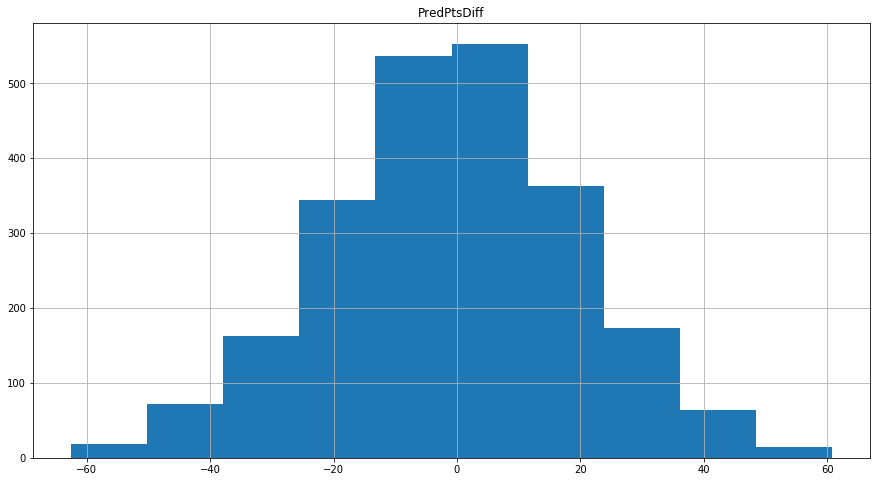

In [25]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [26]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [27]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.436087028571101)
Z score: -0.13167885286707703
Win Prob for Virginia Tech: 44.76%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,4.833875,0.167751
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.666125,-0.167751


In [28]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -12.0 (exact value: -12.385099972715382)
Z score: -0.5755768798017346
Win Prob for Georgia Tech: 28.25%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.444416,-0.611168
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.055584,0.611168


In [29]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.9207133872897183)
Z score: -0.006908735387375578
Win Prob for Georgia Tech: 49.72%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,4.771558,0.043116
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.728442,-0.043116


In [30]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 3.0 (exact value: 3.1325292994956113)
Z score: 0.19414432404848636
Win Prob for Mississippi State: 57.70%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.671141,-0.157719
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,4.828859,0.157719


In [31]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -4.0 (exact value: -4.099753584136611)
Z score: -0.16459871524707498
Win Prob for Texas A&M: 43.46%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,4.850318,0.200635
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.649682,-0.200635


In [32]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Clemson,0.944897,13,12.0,1.0
2,Ohio State,0.943358,13,12.0,1.0
3,Alabama,0.924250,12,11.0,1.0
4,LSU,0.898814,13,12.0,1.0
5,Utah,0.861948,13,11.0,2.0
6,Oregon,0.853980,13,11.0,2.0
7,Wisconsin,0.848622,13,11.0,2.0
8,Notre Dame,0.827971,12,10.0,2.0
9,Georgia,0.822906,13,11.0,2.0
10,Oklahoma,0.799555,13,10.0,3.0


In [33]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.603403,1.396597
21,Clemson,10.814702,2.185298
53,LSU,10.237495,2.762505
115,Utah,9.462902,3.537098
2,Alabama,9.389791,2.610209
128,Wisconsin,9.270254,3.729746
82,Oregon,9.071798,3.928202
78,Oklahoma,8.910783,4.089217
34,Georgia,8.909254,4.090746
75,Notre Dame,8.908271,3.091729


In [129]:
# Matchup Predictor?
def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    if (~(teams[teams.school == team1].conference.isin(p5).all())):
        team1_avg_ffr *= 0.85 # arbitrary
    if (~(teams[teams.school == team2].conference.isin(p5).all())):
        team2_avg_ffr *= 0.85 # arbitrary
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.070610312841243, -29.86065842490973]

In [130]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Clemson,Ohio State,2.5,10.412797,0.701488,True,Clemson,Clemson
0,Penn State,Memphis,7.0,8.733245,0.671941,True,Penn State,Penn State
0,Florida,Virginia,14.0,7.856012,0.656054,False,Florida,Virginia
0,LSU,Oklahoma,11.0,7.267554,0.645238,False,LSU,Oklahoma
0,Wisconsin,Oregon,2.5,-2.571893,0.453777,False,Oregon,Oregon
0,Georgia,Baylor,7.5,-3.546217,0.434666,False,Baylor,Baylor


In [109]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 3.0 (exact value: 2.5162804405494583)
Z score: 0.09182128057460122
Win Prob for Virginia: 53.66%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.688132,-0.123737
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,4.811868,0.123737


In [110]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 8.0 (exact value: 7.743875676633906)
Z score: 0.3538859690921167
Win Prob for North Carolina: 63.83%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,4.94202,0.384039
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.55798,-0.384039


In [111]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 13.0 (exact value: 13.499806730943547)
Z score: 0.6424366718060066
Win Prob for Pittsburgh: 73.97%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.085325,0.670649
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.414675,-0.670649


In [112]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -8.0 (exact value: -7.7683924640341395)
Z score: -0.4237598766350792
Win Prob for Auburn: 33.59%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,4.944189,0.388377
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.555811,-0.388377


In [113]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 29.0 (exact value: 28.558508768422897)
Z score: 1.3973447855194898
Win Prob for Georgia: 91.88%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.460241,1.420481
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.039759,-1.420481


In [114]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 18.0 (exact value: 17.7380223423604)
Z score: 0.8549027492117912
Win Prob for Clemson: 80.37%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 5.0 (exact value: 4.838063537404658)
Z score: 0.20821463863006046
Win Prob for Georgia Tech: 58.25%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -14.0 (exact value: -13.778846648286407)
Z score: -0.725070083816434
Win Prob for The Citadel: 23.42%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 17.0 (exact value: 17.044458486929507)
Z score: 0.820133684750587
Win Prob for Temple: 79.39%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 8.0 (exact value: 7.743875676633906)
Z score: 0.3538859690921167


,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Georgia Tech,Clemson,-38.0,19.630249
5900,401112441,2019,Georgia Tech,South Florida,4.0,58.246931
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,76.579548
6107,401112469,2019,Georgia Tech,Temple,-22.0,20.606995
6164,401112475,2019,Georgia Tech,North Carolina,-16.0,36.171217
6198,401112480,2019,Georgia Tech,Duke,-18.0,34.312192
6251,401112488,2019,Georgia Tech,Miami,7.0,25.847362
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,26.029485
6418,401112504,2019,Georgia Tech,Virginia,-5.0,31.414495
6475,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.433578


In [ ]:
# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)